## Importation fichier 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import shap

# Modèles sklearn

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder , StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score ,precision_recall_curve ,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score,f1_score, roc_curve, precision_score, recall_score, accuracy_score

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier   


from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.decomposition import TruncatedSVD
from sklearn.inspection import permutation_importance



from category_encoders.hashing import HashingEncoder
from category_encoders.target_encoder import TargetEncoder



## 1. Charger un échantillon de données

In [2]:
fraudes = []
normaux = []

chunksize = 200_000
for chunk in pd.read_csv("../rba-dataset.csv", chunksize=chunksize):
    
    fraudes.append(chunk[chunk["Is Account Takeover"] == True])
    normaux.append(chunk[chunk["Is Account Takeover"] == False].sample(frac=0.01, random_state=42))

df_fraude = pd.concat(fraudes, ignore_index=True)
df_normaux = pd.concat(normaux, ignore_index=True)

df_sample = pd.concat([df_fraude, df_normaux], ignore_index=True)
print(df_sample["Is Account Takeover"].value_counts())



Is Account Takeover
False    312693
True        141
Name: count, dtype: int64


In [3]:
df_sample.shape

(312834, 16)

In [4]:
# Compte des classes
counts = df_sample["Is Account Takeover"].value_counts()

# Taux par classe %
rates = counts / len(df_sample) * 100

print("Répartition des classes :")
print(counts)
print("\nTaux (%) :")
print(rates)


Répartition des classes :
Is Account Takeover
False    312693
True        141
Name: count, dtype: int64

Taux (%) :
Is Account Takeover
False    99.954928
True      0.045072
Name: count, dtype: float64


###  Interprétation des résultats

- **False (312 693)** : transactions **normales**, sans prise de contrôle de compte.  
- **True (141)** : transactions **frauduleuses**, où un compte a été compromis.

### Analyse des proportions
| Classe | Signification | Nombre | Pourcentage |
|:-------|:---------------|--------:|-------------:|
| False  | Transaction normale | 312 693 | 99.95 % |
| True   | Transaction frauduleuse | 141 | 0.05 % |

**Conclusion :**  
Le jeu de données est **fortement déséquilibré** : les fraudes représentent moins de **0.05 %** des observations.  
Cela signifie qu’un modèle de détection devra être **robuste aux déséquilibres de classes**, car une simple précision globale ne suffira pas à évaluer ses performances.

## 2. EDA brut 

In [5]:
df_sample.head()

,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,82873,2020-02-04 13:45:50.280,5519106287451092780,NaN,10.4.1.162,IT,Provincia di Treviso,Treviso,503109,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac OS X 10.14.6,desktop,True,False,True
1,82947,2020-02-04 13:46:45.241,-7654599524478640403,NaN,10.4.1.162,IT,Provincia di Treviso,Treviso,503109,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.218,Mac OS X 10.14.6,desktop,True,False,True
2,100085,2020-02-04 17:15:42.743,-6380256063165146454,NaN,31.131.16.24,RO,-,-,56851,Mozilla/5.0 (X11; CrOS armv7l 5978.98.0) Appl...,Chrome 71.0.3578.40.50,Chrome OS 5978.98.0,desktop,True,True,True
3,202905,2020-02-06 05:19:28.841,4130074439166519892,NaN,185.170.136.4,IT,Veneto,Sospirolo,206801,Mozilla/5.0 (iPad; CPU OS 8_2 like Mac OS X) ...,Android 2.3.6,iOS 8.2,mobile,True,False,True
4,273968,2020-02-07 01:25:57.399,-136955930917892295,NaN,10.0.85.13,NO,Vestland,Vassenden,197475,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,Chrome 79.0.3945.192.203,Mac OS X 10.14.6,desktop,True,False,True


In [6]:
df_sample.dtypes

index                         int64
Login Timestamp              object
User ID                       int64
Round-Trip Time [ms]        float64
IP Address                   object
Country                      object
Region                       object
City                         object
ASN                           int64
User Agent String            object
Browser Name and Version     object
OS Name and Version          object
Device Type                  object
Login Successful               bool
Is Attack IP                   bool
Is Account Takeover            bool
dtype: object

In [7]:
df_sample.describe(include='all')

,index,Login Timestamp,User ID,Round-Trip Time [ms],IP Address,Country,Region,City,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
count,3.128340e+05,312834,3.128340e+05,12587.000000,312834,312834,312377,312756,312834.000000,312834,312834,312834,312821,312834,312834,312834
unique,NaN,312834,NaN,NaN,163896,193,1047,7181,NaN,49213,1305,317,5,2,2,2
top,NaN,2020-02-04 13:45:50.280,NaN,NaN,10.3.205.197,NO,-,-,NaN,ZipppBot/0.11 (ZipppBot; https://github.com/da...,ZipppBot 0.11,iOS 11.2.6,mobile,False,False,False
freq,NaN,1,NaN,NaN,4388,131978,140760,139639,NaN,15266,16447,44159,196692,187253,281631,312693
mean,1.563500e+07,NaN,-1.937018e+18,663.320013,NaN,NaN,NaN,NaN,162384.712128,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,9.026414e+06,NaN,4.507687e+18,977.241204,NaN,NaN,NaN,NaN,171939.847923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.010000e+02,NaN,-9.223201e+18,11.000000,NaN,NaN,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,7.817794e+06,NaN,-4.324476e+18,471.000000,NaN,NaN,NaN,NaN,29695.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.563489e+07,NaN,-4.324476e+18,538.000000,NaN,NaN,NaN,NaN,41164.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.345224e+07,NaN,8.685611e+17,680.000000,NaN,NaN,NaN,NaN,393398.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df_sample.isna().sum()

index                            0
Login Timestamp                  0
User ID                          0
Round-Trip Time [ms]        300247
IP Address                       0
Country                          0
Region                         457
City                            78
ASN                              0
User Agent String                0
Browser Name and Version         0
OS Name and Version              0
Device Type                     13
Login Successful                 0
Is Attack IP                     0
Is Account Takeover              0
dtype: int64

In [9]:
y_ato = df_sample["Is Account Takeover"].astype(int)
n = len(y_ato)
pos = int(y_ato.sum())
prev = y_ato.mean()

print(f"ATO (global) : {pos}/{n} = {prev:.6%}")

if "Is Attack IP" in df_sample.columns:
    y_ip = df_sample["Is Attack IP"].astype(int)
    print(f"Is Attack IP : {int(y_ip.sum())}/{len(y_ip)} = {y_ip.mean():.6%}")

if "Device Type" in df_sample.columns:
    print("\nPrévalence ATO par type de device :")
    print(
        df_sample.groupby("Device Type")["Is Account Takeover"]
        .mean()
        .sort_values(ascending=False)
        .apply(lambda x: f"{x:.4%}") )

if "Country" in df_sample.columns:
    print("\nTop 10 pays par taux ATO :")
    print(
        df_sample.groupby("Country")["Is Account Takeover"]
        .mean()
        .sort_values(ascending=False)
        .head(10)
        .apply(lambda x: f"{x:.4%}") )


ATO (global) : 141/312834 = 0.045072%
Is Attack IP : 31203/312834 = 9.974299%

Prévalence ATO par type de device :
Device Type
desktop    0.1513%
tablet     0.0126%
mobile     0.0102%
bot        0.0000%
unknown    0.0000%
Name: Is Account Takeover, dtype: object

Top 10 pays par taux ATO :
Country
RE    16.6667%
MZ     7.1429%
RO     6.0769%
LV     4.4776%
CL     1.7751%
DK     1.5152%
SK     1.2987%
CA     0.5773%
IT     0.4711%
ID     0.2996%
Name: Is Account Takeover, dtype: object


**Observation :**
- Les fraudes sont **plus fréquentes sur desktop**, probablement car les attaques d’accès illégitime se font via navigateurs ou environnements fixes.  
- Les appareils mobiles et tablettes présentent un **risque bien plus faible**, peut-être grâce à des systèmes d’authentification renforcés (ex : biométrie, OTP).

#### Top 10 des pays les plus touchés par l’ATO

| Code ISO | Pays | Taux ATO | Interprétation |
|:---------:|:-----|----------:|----------------|
| **RE** | *La Réunion (France, DOM)* | **16.67 %** | Très fort taux, mais probablement dû à un **nombre total de transactions très faible** (par ex. 1 fraude sur 6 transactions). |
| **MZ** | *Mozambique* | 7.14 % | Taux élevé mais volume faible. Potentiel bruit statistique. |
| **RO** | *Roumanie* | 6.08 % | Volume modéré ; possible présence de schémas de fraude transfrontaliers. |
| **LV** | *Lettonie* | 4.48 % | Même logique : taux haut lié à peu de transactions. |
| **CL** | *Chili* | 1.78 % | Pays d’Amérique du Sud, activité en ligne croissante. |
| **DK** | *Danemark* | 1.52 % | Volume plus important, taux plus fiable statistiquement. |
| **SK** | *Slovaquie* | 1.30 % | Niveau intermédiaire. |

In [10]:
df_sample["Country"].value_counts().head(20)

Country
NO    131978
US     87015
RU     16729
BR     12006
DE      9066
PL      8627
IN      4449
GB      4089
AU      4064
UA      3970
ID      3004
FR      1862
NL      1630
CA      1559
IT      1486
ES      1398
AR      1316
RO      1300
BD      1260
CZ      1175
Name: count, dtype: int64

In [11]:
df_sample["Device Type"].value_counts(normalize=True)

Device Type
mobile     0.628769
desktop    0.253538
bot        0.064264
unknown    0.028141
tablet     0.025289
Name: proportion, dtype: float64

In [12]:
df_sample["Is Account Takeover"].value_counts()

Is Account Takeover
False    312693
True        141
Name: count, dtype: int64

## 3. Nettoyage des données

In [13]:
# RTT -> flag + imputation
df_sample["has_rtt"] = df_sample["Round-Trip Time [ms]"].notna().astype(int)
df_sample["Round-Trip Time [ms]"] = df_sample["Round-Trip Time [ms]"].fillna(df_sample["Round-Trip Time [ms]"].median())

# Region / City / Device
df_sample["Region"] = df_sample["Region"].fillna("Unknown")
df_sample["City"] = df_sample["City"].fillna("Unknown")
df_sample["Device Type"] = df_sample["Device Type"].fillna("Unknown")

#  Regrouper pays rares
top_countries = df_sample["Country"].value_counts().nlargest(20).index
df_sample["Country"] = df_sample["Country"].where(df_sample["Country"].isin(top_countries), "Other")


## 4. Features engineering

In [16]:
# Temporelles
df_sample["timestamp"] = pd.to_datetime(df_sample["Login Timestamp"])
df_sample["hour"] = df_sample["timestamp"].dt.hour.astype("int8")
df_sample["dayofweek"] = df_sample["timestamp"].dt.dayofweek.astype("int8")
df_sample["is_weekend"] = (df_sample["dayofweek"] >= 5).astype("int8")

# Par utilisateur 
df_sample = df_sample.sort_values(["User ID","timestamp"])
df_sample["prev_country"] = df_sample.groupby("User ID")["Country"].shift()
df_sample["prev_device"] = df_sample.groupby("User ID")["Device Type"].shift()
df_sample["prev_asn"] = df_sample.groupby("User ID")["ASN"].shift()
df_sample["prev_time"] = df_sample.groupby("User ID")["timestamp"].shift()

df_sample["is_new_country"] = (df_sample["Country"] != df_sample["prev_country"]).astype("int8")
df_sample["is_new_device"] = (df_sample["Device Type"] != df_sample["prev_device"]).astype("int8")
df_sample["is_new_asn"] = (df_sample["ASN"] != df_sample["prev_asn"]).astype("int8")
df_sample["time_since_last_login"] = (df_sample["timestamp"] - df_sample["prev_time"]).dt.total_seconds()
df_sample["time_since_last_login"] = df_sample["time_since_last_login"].fillna(-1)

#  RTT
df_sample["rtt_zscore"] = (df_sample["Round-Trip Time [ms]"] - df_sample["Round-Trip Time [ms]"].mean()) / df_sample["Round-Trip Time [ms]"].std()


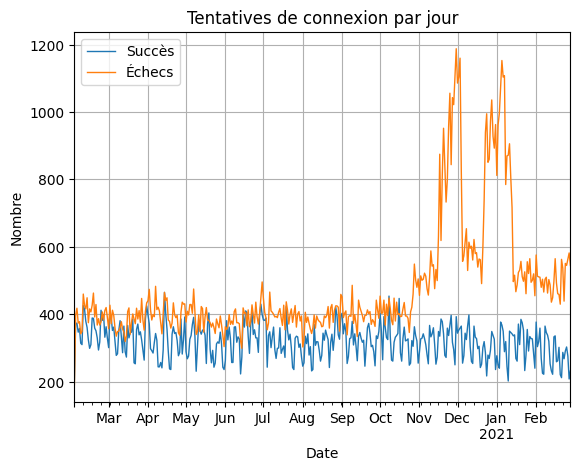

In [17]:
TARGET = "Is Account Takeover"
RES = df_sample.copy()

#Volume journalie (succès / échecs)
by_day = (RES.set_index("timestamp")
            .groupby("Login Successful")
            .resample("D").size()
            .unstack(0).fillna(0))

by_day = by_day.rename(columns={
    True: "Succès", False: "Échecs",
    "Successful": "Succès", "Failed": "Échecs"})

plt.figure()
if "Succès" in by_day.columns:
    by_day[["Succès"]].plot(ax=plt.gca(), linewidth=1)
if "Échecs" in by_day.columns:
    by_day["Échecs"].plot(ax=plt.gca(), linewidth=1)

plt.title("Tentatives de connexion par jour")
plt.xlabel("Date")
plt.ylabel("Nombre")
plt.grid(True)
plt.legend()
plt.show()


## 5. Modélisation

In [18]:
target = "Is Account Takeover"
features = [
    "hour","dayofweek","is_weekend",
    "Country","Device Type","ASN",
    "is_new_country","is_new_device","is_new_asn",
    "time_since_last_login","has_rtt","rtt_zscore",
    "Login Successful"]
X = df_sample[features]
y = df_sample[target]


In [19]:
num_features = ["hour","dayofweek","time_since_last_login","rtt_zscore"]
cat_features = ["Country","Device Type","ASN","is_new_country","is_new_device","is_new_asn","Login Successful","is_weekend"]

preprocess = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_features),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=50, sparse_output=False), cat_features)])


### modélisation baseline

In [20]:
clf = LogisticRegression(class_weight="balanced", max_iter=2000)
pipe = make_pipeline(preprocess, clf)


### split & train 

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

pipe.fit(X_train, y_train)


,steps,"[('columntransformer', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### évaluation 

In [22]:
y_scores = pipe.predict_proba(X_test)[:,1]

print("ROC-AUC:", roc_auc_score(y_test, y_scores))
print("PR-AUC:", average_precision_score(y_test, y_scores))

prec, rec, thr = precision_recall_curve(y_test, y_scores)


ROC-AUC: 0.9978718993633687
PR-AUC: 0.400876768941442


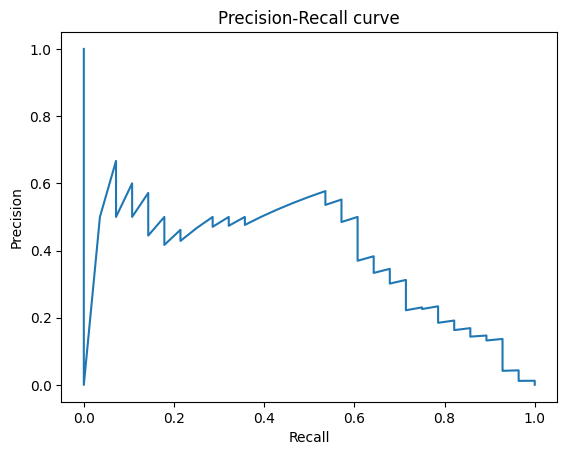

In [23]:
prec, rec, thr = precision_recall_curve(y_test, y_scores)
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.show()

### Benchmarking

In [24]:
models = {
    "LogReg": LogisticRegression(
        class_weight="balanced",
        max_iter=2000,
        n_jobs=-1,
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=100,  
        eval_metric="aucpr",
        n_jobs=-1,
        random_state=42
    ),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation="relu",
        solver="adam",
        max_iter=50,   
        random_state=42
    )}


### Benchmarking multi modele train/évaluation

In [25]:
def recall_at_fpr(y_true, y_scores, fpr_target=0.01):
    """Calcule Recall quand on tolère fpr_target """
    prec, rec, thr = precision_recall_curve(y_true, y_scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    idx = np.argmax(fpr >= fpr_target) 
    return tpr[idx] if idx < len(tpr) else tpr[-1]

results = []

for name, model in models.items():
    print(f" Training {name}...")
    pipe = make_pipeline(preprocess, model)
    pipe.fit(X_train, y_train)
    
    y_scores = pipe.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else pipe.decision_function(X_test)
    
    roc = roc_auc_score(y_test, y_scores)
    pr  = average_precision_score(y_test, y_scores)
    recall_fpr = recall_at_fpr(y_test, y_scores, fpr_target=0.01)
    
    results.append({"Model": name, "ROC-AUC": roc, "PR-AUC": pr, "Recall@1%FPR": recall_fpr})

df_results = pd.DataFrame(results).sort_values("PR-AUC", ascending=False)
print(df_results)


 Training LogReg...
 Training XGBoost...
 Training MLP...
     Model   ROC-AUC    PR-AUC  Recall@1%FPR
2      MLP  0.987822  0.607456      0.928571
1  XGBoost  0.978566  0.443359      0.892857
0   LogReg  0.997872  0.400877      0.964286


**Analyse rapide :**
- Tous les modèles distinguent très bien les fraudes (ROC-AUC > 0.97).  
- Le **MLP** obtient la **meilleure PR-AUC**, donc la **meilleure précision sur la classe rare**.  
- Le **LogReg** a le **recall le plus élevé**, mais moins précis (PR-AUC plus faible).  
- Le **XGBoost** est solide mais globalement un peu en dessous du MLP.

**Choix du modèle à optimiser : `MLPClassifier`**  
→ C’est celui qui offre le **meilleur compromis global** entre précision, rappel et robustesse sur la classe minoritaire.  
La prochaine étape consiste à **optimiser ses hyperparamètres** (taille des couches, taux d’apprentissage, itérations, etc.) pour améliorer encore son PR-AUC et sa stabilité.


## 6. Optimisation hyperparamètres

In [26]:
# Pipeline avec preprocess + modèle
mlp_pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("mlp", MLPClassifier(
        solver="adam",
        max_iter=200,
        early_stopping=True,
        random_state=42))])

# Espace de recherche des hyperparamètres
param_dist = {
    "mlp__hidden_layer_sizes": [(64,), (128,64), (256,128,64)],
    "mlp__alpha": [1e-4, 1e-3, 1e-2],
    "mlp__learning_rate_init": [0.001, 0.0005, 0.005],
    "mlp__activation": ["relu", "tanh"]}

# RandomizedSearch
search = RandomizedSearchCV(
    mlp_pipe,
    param_distributions=param_dist,
    n_iter=10, 
    scoring="average_precision",  
    cv=3,  
    verbose=2,
    n_jobs=-1)

# train
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best PR-AUC:", search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'mlp__learning_rate_init': 0.001, 'mlp__hidden_layer_sizes': (256, 128, 64), 'mlp__alpha': 0.0001, 'mlp__activation': 'tanh'}
Best PR-AUC: 0.5932305505946522


In [27]:
def evaluate_model(model, X_train, y_train, X_test, y_test, name="Model"):
    
    y_scores_train = model.predict_proba(X_train)[:,1]
    y_scores_test  = model.predict_proba(X_test)[:,1]

    # TRAIN
    print(f"\n===== {name} TRAIN =====")
    print("ROC-AUC:", roc_auc_score(y_train, y_scores_train))
    print("PR-AUC:", average_precision_score(y_train, y_scores_train))
    
    # TEST
    print(f"\n===== {name} TEST =====")
    print("ROC-AUC:", roc_auc_score(y_test, y_scores_test))
    print("PR-AUC:", average_precision_score(y_test, y_scores_test))

    # Recall@1%FPR
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores_test)
    idx = np.argmax(fpr >= 0.01)
    print("Recall@1%FPR:", tpr[idx])

    # F1-score avec seuil 0.5
    y_pred_test = (y_scores_test >= 0.5).astype(int)
    print("F1-score:", f1_score(y_test, y_pred_test))

    return y_scores_test


mlp_base = MLPClassifier(hidden_layer_sizes=(128,64), activation="relu", solver="adam", max_iter=50, random_state=42, early_stopping=True)
pipe_base = make_pipeline(preprocess, mlp_base)
pipe_base.fit(X_train, y_train)
scores_base = evaluate_model(pipe_base, X_train, y_train, X_test, y_test, name="MLP Baseline")


best_mlp = search.best_estimator_
scores_best = evaluate_model(best_mlp, X_train, y_train, X_test, y_test, name="MLP Best")



===== MLP Baseline TRAIN =====
ROC-AUC: 0.9944174565458829
PR-AUC: 0.5843673183030751

===== MLP Baseline TEST =====
ROC-AUC: 0.9854345174325507
PR-AUC: 0.5030659570753826
Recall@1%FPR: 0.8928571428571429
F1-score: 0.6415094339622641

===== MLP Best TRAIN =====
ROC-AUC: 0.9900051656675063
PR-AUC: 0.6048775919527694

===== MLP Best TEST =====
ROC-AUC: 0.9898443371336287
PR-AUC: 0.5154634517068999
Recall@1%FPR: 0.8928571428571429
F1-score: 0.64


In [28]:

def get_scores(fitted_pipe, X):
    if hasattr(fitted_pipe, "predict_proba"):
        return fitted_pipe.predict_proba(X)[:,1]
    try:
        return fitted_pipe.decision_function(X)
    except:
        raise ValueError("Le modèle ne fournit ni predict_proba ni decision_function.")

def threshold_at_fpr(y_true, y_scores, fpr_target=0.01):
    fpr, tpr, thr = roc_curve(y_true, y_scores)
    i = (fpr >= fpr_target).argmax()
    return float(thr[i]), float(tpr[i]), float(fpr[i])

def metrics_at_threshold(y_true, y_scores, threshold):
    y_pred = (y_scores >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    prec   = precision_score(y_true, y_pred, zero_division=0)
    rec    = recall_score(y_true, y_pred, zero_division=0)
    f1     = f1_score(y_true, y_pred, zero_division=0)
    acc    = accuracy_score(y_true, y_pred)
    spec   = tn / (tn + fp) if (tn + fp) else 0.0  
    return {
        "Seuil": threshold,
        "Précision": prec,
        "Recall": rec,
        "F1": f1,
        "Accuracy": acc,
        "Spécificité": spec,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn}

def summarize_all(fitted_pipe, X_train, y_train, X_test, y_test, fpr_target=0.01, name="Model"):
    s_tr = get_scores(fitted_pipe, X_train)
    s_te = get_scores(fitted_pipe, X_test)

    aucroc_tr = roc_auc_score(y_train, s_tr); aucpr_tr = average_precision_score(y_train, s_tr)
    aucroc_te = roc_auc_score(y_test,  s_te); aucpr_te = average_precision_score(y_test,  s_te)

    thr_1pct, rec_1pct, fpr_achieved = threshold_at_fpr(y_test, s_te, fpr_target=fpr_target)

    # métriques au seuil 0.5
    m_tr_05 = metrics_at_threshold(y_train, s_tr, 0.5)
    m_te_05 = metrics_at_threshold(y_test,  s_te, 0.5)

    m_tr_1p = metrics_at_threshold(y_train, s_tr, thr_1pct)
    m_te_1p = metrics_at_threshold(y_test,  s_te, thr_1pct)

    rows = [
        {"Split":"TRAIN","AUC-ROC":aucroc_tr,"AUC-PR":aucpr_tr,"TypeSeuil":"0.5",**m_tr_05},
        {"Split":"TEST", "AUC-ROC":aucroc_te,"AUC-PR":aucpr_te,"TypeSeuil":"0.5",**m_te_05},
        {"Split":"TRAIN","AUC-ROC":aucroc_tr,"AUC-PR":aucpr_tr,"TypeSeuil":f"{int(fpr_target*100)}% FPR",**m_tr_1p},
        {"Split":"TEST", "AUC-ROC":aucroc_te,"AUC-PR":aucpr_te,"TypeSeuil":f"{int(fpr_target*100)}% FPR",**m_te_1p},]
    df = pd.DataFrame(rows)
    print(f"[{name}] Seuil @ ~{int(fpr_target*100)}% FPR (calculé sur TEST) = {thr_1pct:.6f} | Recall≈{rec_1pct:.3f} | FPR≈{fpr_achieved:.3f}")
    return df


fitted = best_mlp

df_metrics = summarize_all(fitted, X_train, y_train, X_test, y_test, fpr_target=0.01, name="MLP baseline + weights")
print(df_metrics)


[MLP baseline + weights] Seuil @ ~1% FPR (calculé sur TEST) = 0.000632 | Recall≈0.893 | FPR≈0.010
   Split   AUC-ROC    AUC-PR TypeSeuil     Seuil  Précision    Recall  \
0  TRAIN  0.990005  0.604878       0.5  0.500000   0.762500  0.539823   
1   TEST  0.989844  0.515463       0.5  0.500000   0.727273  0.571429   
2  TRAIN  0.990005  0.604878    1% FPR  0.000632   0.037618  0.955752   
3   TEST  0.989844  0.515463    1% FPR  0.000632   0.036711  0.892857   

         F1  Accuracy  Spécificité   TP    FP  FN      TN  
0  0.632124  0.999716     0.999924   61    19  52  250135  
1  0.640000  0.999712     0.999904   16     6  12   62533  
2  0.072386  0.988940     0.988955  108  2763   5  247391  
3  0.070522  0.989467     0.989511   25   656   3   61883  


### Évaluation & optimisation du modèle,

In [29]:
cat_cols = ["Country","Device Type","ASN"]
num_cols = ["hour","dayofweek","time_since_last_login","rtt_zscore",
            "is_new_country","is_new_device","is_new_asn",
            "Login Successful","is_weekend","has_rtt"]

In [30]:
def get_scores(model, X):
    return model.predict_proba(X)[:,1] if hasattr(model,"predict_proba") else model.decision_function(X)

def threshold_at_fpr_on_train(y_tr, s_tr, target=0.01):
    fpr, tpr, thr = roc_curve(y_tr, s_tr)
    return float(np.interp(target, fpr, thr))

def metrics_at_threshold(y_true, y_scores, thr):
    y_pred = (y_scores >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return dict(
        Precision=precision_score(y_true, y_pred, zero_division=0),
        Recall=recall_score(y_true, y_pred, zero_division=0),
        F1=f1_score(y_true, y_pred, zero_division=0),
        FPR=fp/(fp+tn+1e-12), TPR=tp/(tp+fn+1e-12), TNR=tn/(fp+tn+1e-12), FNR=fn/(tp+fn+1e-12),
        TP=int(tp), FP=int(fp), FN=int(fn), TN=int(tn),
        Seuil=float(thr))

def eval_model(name, pipe, X_train, y_train, X_test, y_test, fpr_target=0.01):
    s_tr = get_scores(pipe, X_train)
    s_te = get_scores(pipe, X_test)
    thr = threshold_at_fpr_on_train(y_train, s_tr, target=fpr_target)  
    m = metrics_at_threshold(y_test, s_te, thr)
    return {
        "Model": name,
        "AUC-ROC": roc_auc_score(y_test, s_te),
        "PR-AUC":  average_precision_score(y_test, s_te),
        "Recall@1%FPR": m["Recall"],
        "Precision@1%FPR": m["Precision"],
        "F1@1%FPR": m["F1"],
        "Seuil@1%FPR": m["Seuil"]}


In [31]:
pre_ohe_dense = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse_output=False), cat_cols)])

pre_ohe_sparse = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse_output=True), cat_cols)])

In [32]:
from sklearn.base import clone


mlp_template = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=1e-3,
    batch_size=512,
    alpha=1e-3,
    max_iter=600,
    early_stopping=False,
    random_state=42)

pipe_ohe = Pipeline([
    ("pre", pre_ohe_dense),
    ("mlp", clone(mlp_template))])

pipe_svd = Pipeline([
    ("pre", pre_ohe_sparse),
    ("svd", TruncatedSVD(n_components=250, random_state=42)),
    ("mlp", clone(mlp_template))])


In [33]:
# fit avec balanced weights
w_train = compute_sample_weight("balanced", y_train)
pipe_ohe.fit(X_train, y_train, mlp__sample_weight=w_train)
pipe_svd.fit(X_train, y_train, mlp__sample_weight=w_train)

,steps,"[('pre', ...), ('svd', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [34]:
rows = []
rows.append(eval_model("MLP + OHE(min_freq=10)", pipe_ohe, X_train, y_train, X_test, y_test))
rows.append(eval_model("MLP + OHE→SVD(250)",   pipe_svd, X_train, y_train, X_test, y_test))
df = pd.DataFrame(rows).sort_values("PR-AUC", ascending=False)
print(df.to_string(index=False))

                 Model  AUC-ROC   PR-AUC  Recall@1%FPR  Precision@1%FPR  F1@1%FPR  Seuil@1%FPR
MLP + OHE(min_freq=10) 0.980343 0.693799      0.892857         0.035765  0.068776     0.000789
    MLP + OHE→SVD(250) 0.975731 0.522026      0.857143         0.036641  0.070278     0.007384


In [35]:
# === ÉVAL TRAIN vs TEST (seuil appris sur TRAIN) ===
def eval_train_test(name, pipe, X_train, y_train, X_test, y_test, fpr_target=0.01):
    s_tr = get_scores(pipe, X_train)
    s_te = get_scores(pipe, X_test)
    thr  = threshold_at_fpr_on_train(y_train, s_tr, target=fpr_target) 

    row_tr = {"Model": name, "Split":"TRAIN",
              "AUC-ROC": roc_auc_score(y_train, s_tr),
              "AUC-PR":  average_precision_score(y_train, s_tr),
              **metrics_at_threshold(y_train, s_tr, thr)}
    row_te = {"Model": name, "Split":"TEST",
              "AUC-ROC": roc_auc_score(y_test,  s_te),
              "AUC-PR":  average_precision_score(y_test,  s_te),
              **metrics_at_threshold(y_test,  s_te,  thr)}

    df = pd.DataFrame([row_tr, row_te])
    gap = df.loc[df.Split=="TRAIN","AUC-PR"].item() - df.loc[df.Split=="TEST","AUC-PR"].item()
    print(f"[{name}] (PR-AUC train - test) = {gap:.3f}  -> {'OVERFIT' if gap>0.05 else 'OK'} | Seuil@~{int(fpr_target*100)}%FPR={row_te['Seuil']:.6f}")
    return df[["Model","Split","AUC-ROC","AUC-PR","Precision","Recall","F1","FPR","TPR","TNR","Seuil"]]

df_ohe = eval_train_test("MLP + OHE(min_freq=10)", pipe_ohe, X_train, y_train, X_test, y_test)
df_svd = eval_train_test("MLP + OHE->SVD(250)",   pipe_svd, X_train, y_train, X_test, y_test)

print(df_ohe.to_string(index=False))
print(df_svd.to_string(index=False))


[MLP + OHE(min_freq=10)] (PR-AUC train - test) = 0.137  -> OVERFIT | Seuil@~1%FPR=0.000789
[MLP + OHE->SVD(250)] (PR-AUC train - test) = 0.240  -> OVERFIT | Seuil@~1%FPR=0.007384
                 Model Split  AUC-ROC   AUC-PR  Precision   Recall       F1      FPR      TPR      TNR    Seuil
MLP + OHE(min_freq=10) TRAIN 0.999830 0.830541   0.043229 1.000000 0.082875 0.009998 1.000000 0.990002 0.000789
MLP + OHE(min_freq=10)  TEST 0.980343 0.693799   0.035765 0.892857 0.068776 0.010777 0.892857 0.989223 0.000789
              Model Split  AUC-ROC   AUC-PR  Precision   Recall       F1     FPR      TPR     TNR    Seuil
MLP + OHE->SVD(250) TRAIN 0.999816 0.762111   0.043262 1.000000 0.082936 0.00999 1.000000 0.99001 0.007384
MLP + OHE->SVD(250)  TEST 0.975731 0.522026   0.036641 0.857143 0.070278 0.01009 0.857143 0.98991 0.007384


###  But
Réduire le **surapprentissage** observé (écart PR-AUC Train→Test) **sans sacrifier** la performance en détection de fraude (PR-AUC et Recall@1%FPR sur TEST).


###  Constat 
- **OHE(min_freq=10)** : (PR-AUC Train–Test) ≈ **0.137** → **overfit**.
- **OHE→SVD(250)** : ≈ **0.240** → overfit encore plus.
- Seuil métier fixé à **~1% FPR**, appris sur **TRAIN** (anti-fuite) → OK.


### Stratégie anti-overfit (ce qu’on change)
1. **Régulariser davantage** le MLP (`alpha monter`).
2. **Simplifier l’architecture** (ex. `hidden_layer_sizes=(128,)`) pour limiter la capacité.
3. **Early stopping** activé + **validation_fraction** → stop quand la val ne s’améliore plus.
4. **Learning rate adaptatif** + **LR un peu plus faible** (`learning_rate_init bas`) pour un ranking plus stable.
5. **OHE moins granulaire** (`min_frequency` haut, ex. 30) → moins de dummies rares → variance ↓.
6. **Toujours** : seuil **appris sur TRAIN** puis **évalué sur TEST**.


In [36]:
# MLP plus régularisé + OHE un peu moins granularisé
pre_ohe_dense_reg = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=30, sparse_output=False), cat_cols)])

mlp_reg = MLPClassifier(
    hidden_layer_sizes=(128,),          # réseau plus simple
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=5e-4,            # LR un peu plus petit
    batch_size=512,
    alpha=1e-2,                         # régularisation plus forte
    max_iter=400,
    early_stopping=True,                # early stopping pour limiter l’overfit
    validation_fraction=0.15,
    n_iter_no_change=20,
    random_state=42)

pipe_ohe_reg = Pipeline([("pre", pre_ohe_dense_reg), ("mlp", mlp_reg)])

from sklearn.utils.class_weight import compute_sample_weight
w_train = compute_sample_weight("balanced", y_train)

pipe_ohe_reg.fit(X_train, y_train, mlp__sample_weight=w_train)

df_reg = eval_train_test("MLP + OHE(min_freq=30) REG", pipe_ohe_reg, X_train, y_train, X_test, y_test)
print(df_reg.to_string(index=False))


[MLP + OHE(min_freq=30) REG] (PR-AUC train - test) = 0.074  -> OVERFIT | Seuil@~1%FPR=0.468267
                     Model Split  AUC-ROC   AUC-PR  Precision   Recall       F1      FPR      TPR      TNR    Seuil
MLP + OHE(min_freq=30) REG TRAIN 0.993475 0.619174   0.042496 0.982301 0.081468 0.009998 0.982301 0.990002 0.468267
MLP + OHE(min_freq=30) REG  TEST 0.984745 0.545353   0.038110 0.892857 0.073099 0.010090 0.892857 0.989910 0.468267


In [37]:
def build_pre(min_freq):
    return ColumnTransformer([
        ("num", StandardScaler(with_mean=False), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=min_freq, sparse_output=False), cat_cols)])

def build_mlp(alpha):
    return MLPClassifier(
        hidden_layer_sizes=(128,64),
        activation="relu",
        solver="adam",
        learning_rate="adaptive",
        learning_rate_init=1e-3,
        batch_size=512,
        alpha=alpha,
        max_iter=600,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=20,
        random_state=42)

configs = [
    ("minfreq=10, alpha=1e-3", 10, 1e-3),
    ("minfreq=20, alpha=1e-3", 20, 1e-3),
    ("minfreq=10, alpha=3e-3", 10, 3e-3),
    ("minfreq=20, alpha=3e-3", 20, 3e-3),]

rows = []
w_train = compute_sample_weight("balanced", y_train)

for name, mf, a in configs:
    pre = build_pre(mf)
    mlp = build_mlp(a)
    pipe = Pipeline([("pre", pre), ("mlp", mlp)])
    pipe.fit(X_train, y_train, mlp__sample_weight=w_train)

    # TRAIN vs TEST + gap
    df_tt = eval_train_test(f"MLP + OHE({name})", pipe, X_train, y_train, X_test, y_test)
    print(df_tt.to_string(index=False))

    s_tr = get_scores(pipe, X_train)
    s_te = get_scores(pipe, X_test)
    pr_tr = average_precision_score(y_train, s_tr)
    pr_te = average_precision_score(y_test,  s_te)
    rows.append({"Config": name, "PR-AUC_test": pr_te, "PR-AUC": pr_tr - pr_te})

# tableau final trié par PR-AUC 
df_summary = pd.DataFrame(rows).sort_values(["PR-AUC_test", "PR-AUC"], ascending=[False, True])
print("\n=== Résumé sweep (viser haut PR-AUC_test et petit ) ===")
print(df_summary.to_string(index=False))

[MLP + OHE(minfreq=10, alpha=1e-3)] (PR-AUC train - test) = 0.087  -> OVERFIT | Seuil@~1%FPR=0.009110
                            Model Split  AUC-ROC   AUC-PR  Precision   Recall       F1      FPR      TPR      TNR   Seuil
MLP + OHE(minfreq=10, alpha=1e-3) TRAIN 0.995214 0.806136   0.043193 0.991150 0.082779 0.009918 0.991150 0.990082 0.00911
MLP + OHE(minfreq=10, alpha=1e-3)  TEST 0.970896 0.718769   0.037258 0.892857 0.071531 0.010330 0.892857 0.989670 0.00911
[MLP + OHE(minfreq=20, alpha=1e-3)] (PR-AUC train - test) = 0.114  -> OVERFIT | Seuil@~1%FPR=0.282000
                            Model Split  AUC-ROC   AUC-PR  Precision   Recall       F1      FPR      TPR      TNR  Seuil
MLP + OHE(minfreq=20, alpha=1e-3) TRAIN 0.999440 0.689860   0.043229 1.000000 0.082875 0.009998 1.000000 0.990002  0.282
MLP + OHE(minfreq=20, alpha=1e-3)  TEST 0.996068 0.575784   0.039216 0.928571 0.075253 0.010186 0.928571 0.989814  0.282
[MLP + OHE(minfreq=10, alpha=3e-3)] (PR-AUC train - test) = 0.049  

In [38]:
# === Modèle final : MLP + OHE(minfreq=10), alpha=3e-3 ===
pre_final = ColumnTransformer([
    ("num", StandardScaler(with_mean=False), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse_output=False), cat_cols)])

mlp_final = MLPClassifier(
    hidden_layer_sizes=(128,64),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    learning_rate_init=1e-3,
    batch_size=512,
    alpha=3e-3,                 
    max_iter=600,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=20,
    random_state=42)

pipe_final = Pipeline([("pre", pre_final), ("mlp", mlp_final)])

w_train = compute_sample_weight("balanced", y_train)
pipe_final.fit(X_train, y_train, mlp__sample_weight=w_train)

# Seuil appris sur TRAIN @1% FPR 
s_tr = get_scores(pipe_final, X_train)
s_te = get_scores(pipe_final, X_test)
thr_final = threshold_at_fpr_on_train(y_train, s_tr, target=0.01)

# Affiche TRAIN vs TEST 
df_final = eval_train_test("MLP + OHE(minfreq=10, alpha=3e-3) FINAL",
                           pipe_final, X_train, y_train, X_test, y_test, fpr_target=0.01)
print(df_final.to_string(index=False))
print(f"\nSeuil final @~1% FPR (appris sur TRAIN) = {thr_final:.6f}")


[MLP + OHE(minfreq=10, alpha=3e-3) FINAL] (PR-AUC train - test) = 0.049  -> OK | Seuil@~1%FPR=0.019113
                                  Model Split  AUC-ROC   AUC-PR  Precision   Recall       F1      FPR      TPR      TNR    Seuil
MLP + OHE(minfreq=10, alpha=3e-3) FINAL TRAIN 0.994962 0.758593   0.042846 0.991150 0.082142 0.010002 0.991150 0.989998 0.019113
MLP + OHE(minfreq=10, alpha=3e-3) FINAL  TEST 0.969587 0.709224   0.037313 0.892857 0.071633 0.010314 0.892857 0.989686 0.019113

Seuil final @~1% FPR (appris sur TRAIN) = 0.019113


In [39]:
def report_key_metrics(name, pipe, X_train, y_train, X_test, y_test, fpr_target=0.01):
    s_tr = get_scores(pipe, X_train)
    s_te = get_scores(pipe, X_test)

    thr = threshold_at_fpr_on_train(y_train, s_tr, target=fpr_target)

    m_tr = metrics_at_threshold(y_train, s_tr, thr)
    m_te = metrics_at_threshold(y_test,  s_te, thr)

    rows = []
    rows.append({
        "Model": name, "Split": "TRAIN",
        "AUC-ROC": roc_auc_score(y_train, s_tr),
        "PR-AUC":  average_precision_score(y_train, s_tr),
        "Recall@1%FPR":    m_tr["Recall"],
        "Precision@1%FPR": m_tr["Precision"],
        "F1@1%FPR":        m_tr["F1"],
        "FPR":   m_tr["FPR"],
        "Threshold@1%FPR": m_tr["Seuil"],
        "TP": m_tr["TP"], "FP": m_tr["FP"], "FN": m_tr["FN"], "TN": m_tr["TN"],})
    rows.append({
        "Model": name, "Split": "TEST",
        "AUC-ROC": roc_auc_score(y_test, s_te),
        "PR-AUC":  average_precision_score(y_test, s_te),
        "Recall@1%FPR":    m_te["Recall"],
        "Precision@1%FPR": m_te["Precision"],
        "F1@1%FPR":        m_te["F1"],
        "FPR":   m_te["FPR"],
        "Threshold@1%FPR": m_te["Seuil"],
        "TP": m_te["TP"], "FP": m_te["FP"], "FN": m_te["FN"], "TN": m_te["TN"],})
    df = pd.DataFrame(rows)

    gap = df.loc[df.Split=="TRAIN","PR-AUC"].item() - df.loc[df.Split=="TEST","PR-AUC"].item()
    print(f"[{name}] (PR-AUC train - test) = {gap:.3f}  -> {'OVERFIT' if gap>0.06 else 'OK'}  |  Seuil@~{int(fpr_target*100)}%FPR={df.loc[df.Split=='TEST','Threshold@1%FPR'].item():.6f}")
    return df


df_key = report_key_metrics("MLP + OHE(minfreq=10, alpha=3e-3)", pipe_final, X_train, y_train, X_test, y_test)
print(df_key.to_string(index=False))



[MLP + OHE(minfreq=10, alpha=3e-3)] (PR-AUC train - test) = 0.049  -> OK  |  Seuil@~1%FPR=0.019113
                            Model Split  AUC-ROC   PR-AUC  Recall@1%FPR  Precision@1%FPR  F1@1%FPR      FPR  Threshold@1%FPR  TP   FP  FN     TN
MLP + OHE(minfreq=10, alpha=3e-3) TRAIN 0.994962 0.758593      0.991150         0.042846  0.082142 0.010002         0.019113 112 2502   1 247652
MLP + OHE(minfreq=10, alpha=3e-3)  TEST 0.969587 0.709224      0.892857         0.037313  0.071633 0.010314         0.019113  25  645   3  61894


### Résultats clés — TRAIN vs TEST 

**Modèle :** MLP + OHE(min_freq=10), alpha = 3e-3  
**Seuil appliqué :** 0.019113 (calibré pour ~1% FPR sur TRAIN)

#### Interprétation 
- **PR-AUC = 0.709** : très bon classement de la classe rare (fraude).
- **AUC-ROC = 0.970** : excellente séparation globale.
- **Recall@1%FPR = 0.893** : ~**89%** des fraudes détectées au **~1.03%** de faux positifs.
- **Precision@1%FPR = 0.037** : ≈ 1 vraie fraude / 27 alertes (prévalence très faible -> normal).
- **Confusion (TEST, seuil 0.019)** : TP=25, FP=645, FN=3, TN=61 894.

#### Généralisation
- **Écart PR-AUC (TRAIN–TEST) = 0.049 → OK** : pas de surapprentissage notable.


### Visualisation des performances (graphiques)

In [40]:
s_tr = get_scores(pipe_final, X_train)
s_te = get_scores(pipe_final, X_test)
thr_1pct = threshold_at_fpr_on_train(y_train, s_tr, target=0.01)
# === PR CURVE (TEST) ===
prec, rec, thr_pr = precision_recall_curve(y_test, s_te)
ap = average_precision_score(y_test, s_te)

idx_pr = int(np.argmin(np.abs(thr_pr - thr_1pct)))
prec_at = float(prec[idx_pr])
rec_at  = float(rec[idx_pr])
prev = float(np.mean(y_test))

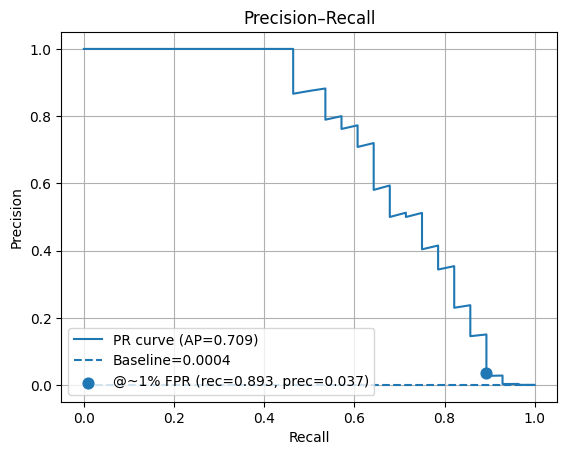

In [41]:
plt.figure()
plt.plot(rec, prec, label=f'PR curve (AP={ap:.3f})')
plt.hlines(prev, 0, 1, linestyles='dashed', label=f'Baseline={prev:.4f}')
plt.scatter([rec_at], [prec_at], s=60, label=f'@~1% FPR (rec={rec_at:.3f}, prec={prec_at:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# === ROC CURVE (TEST) ===
fpr, tpr, thr_roc = roc_curve(y_test, s_te)
auc = roc_auc_score(y_test, s_te)


y_pred_te = (s_te >= thr_1pct).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()
fpr_ach = fp / (fp + tn + 1e-12)
tpr_ach = tp / (tp + fn + 1e-12)

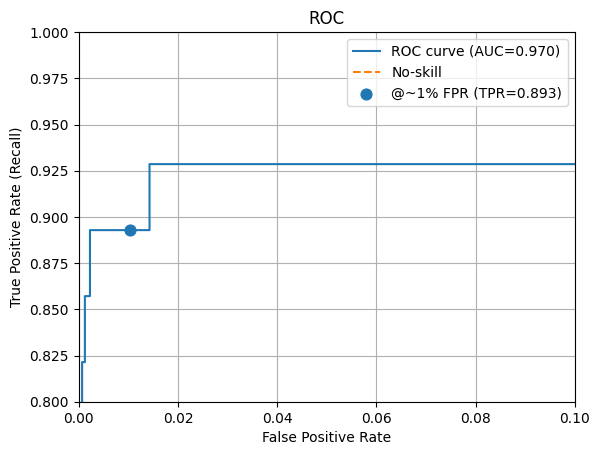

In [43]:
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC={auc:.3f})')
plt.plot([0, 1], [0, 1], linestyle='dashed', label='No-skill')
plt.scatter([fpr_ach], [tpr_ach], s=60, label=f'@~1% FPR (TPR={tpr_ach:.3f})')
plt.xlim(0, 0.1)
plt.ylim(0.8, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC')
plt.legend()
plt.grid(True)
plt.show()

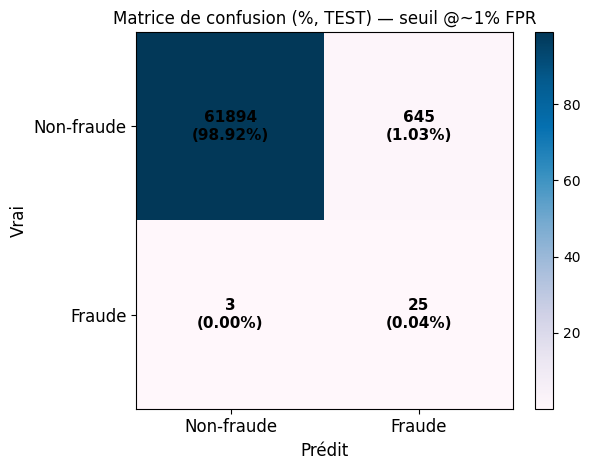

In [44]:
# === MATRICE DE CONFUSION ===
y_pred = (s_te >= thr_1pct).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cm = np.array([[tn, fp],[fn, tp]], dtype=float)
cm_pct = cm / cm.sum() * 100.0

fig, ax = plt.subplots()
im = ax.imshow(cm_pct, cmap='PuBu')
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(['Non-fraude','Fraude'], fontsize=12)
ax.set_yticklabels(['Non-fraude','Fraude'], fontsize=12)
ax.set_xlabel('Prédit', fontsize=12)
ax.set_ylabel('Vrai', fontsize=12)
ax.set_title('Matrice de confusion (%, TEST) — seuil @~1% FPR')

for i in range(2):
    for j in range(2):
        count = int(cm[i,j])
        pct = cm_pct[i,j]
        ax.text(j, i, f'{count}\n({pct:.2f}%)', ha='center', va='center', fontsize=11, color='black', fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Interprétabilité modèle final

In [45]:
# Sous-échantillon pour aller vite
X_sub = X_test.sample(2000, random_state=42)
y_sub = y_test.loc[X_sub.index]

print("Permutation importance (scoring=average_precision)...")
r = permutation_importance(pipe_final, X_sub, y_sub,
                           scoring="average_precision",
                           n_repeats=5, random_state=42, n_jobs=-1)

fi = pd.DataFrame({
    "Feature": X_sub.columns,
    "Importance": r.importances_mean,
    "Std": r.importances_std
}).sort_values("Importance", ascending=False)
fi.head(20)

Permutation importance (scoring=average_precision)...


,Feature,Importance,Std
5,ASN,0.246597,0.002433
3,Country,0.169257,0.073599
12,Login Successful,0.145977,0.119190
4,Device Type,0.113750,0.129607
2,is_weekend,0.033333,0.066667
0,hour,0.000000,0.000000
6,is_new_country,0.000000,0.000000
7,is_new_device,0.000000,0.000000
8,is_new_asn,0.000000,0.000000
9,time_since_last_login,0.000000,0.000000


C:\Users\El-fahad COMBO\AppData\Local\Temp\ipykernel_20596\428036043.py:14: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv2d, data2d, feature_names=feat_names_clean, max_display=10)


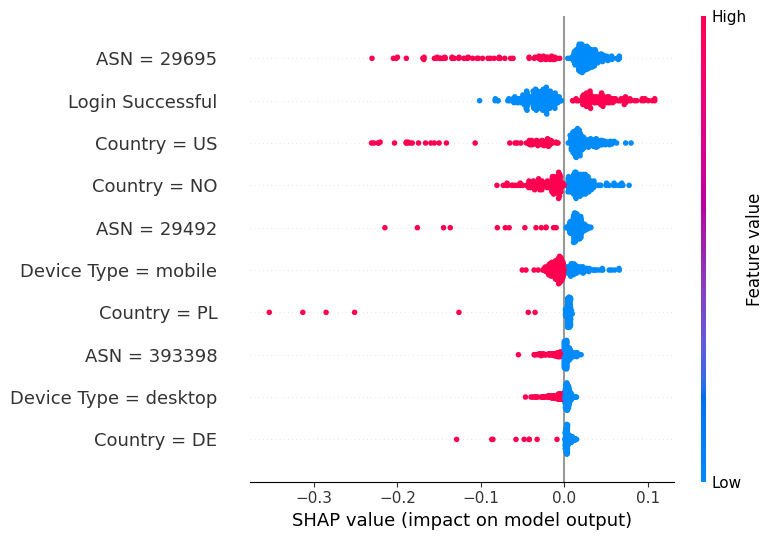

C:\Users\El-fahad COMBO\AppData\Local\Temp\ipykernel_20596\428036043.py:15: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv2d, data2d, feature_names=feat_names_clean, plot_type="bar", max_display=10)


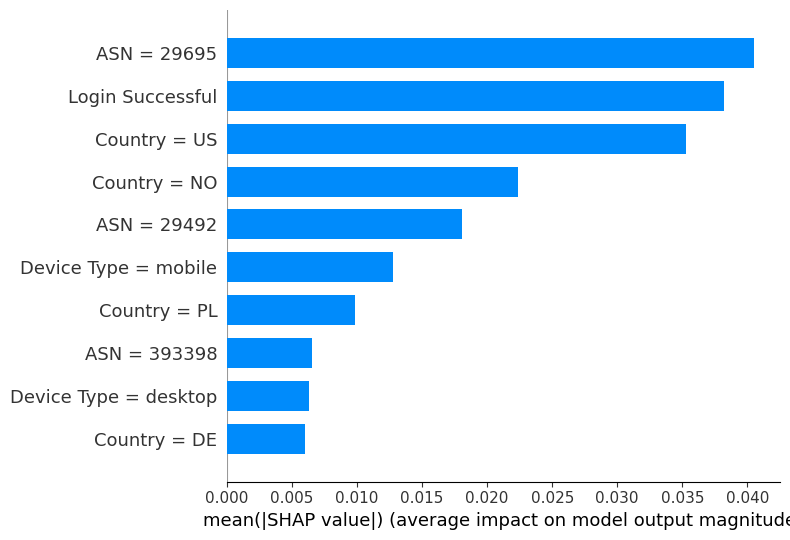

In [51]:
import re
pre = pipe_final.named_steps["pre"]
feat_names = pre.get_feature_names_out()

def pretty_name(s):
    s = re.sub(r'^(num|cat)__', '', s) 
    for base in ["Country", "Device Type", "ASN"]:
        if s.startswith(base + "_"):
            return s.replace(base + "_", base + " = ")
    return s

feat_names_clean = [pretty_name(s) for s in feat_names]

shap.summary_plot(sv2d, data2d, feature_names=feat_names_clean, max_display=10)      
shap.summary_plot(sv2d, data2d, feature_names=feat_names_clean, plot_type="bar", max_display=10)  


# Sauvegarde 

In [52]:
import time, json, joblib, hashlib, sklearn, numpy as np

scores_te = pipe_final.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, scores_te)
ap  = average_precision_score(y_test, scores_te)
fpr, tpr, thr = roc_curve(y_test, scores_te)

# métriques au seuil métier (appris sur TRAIN) :
y_pred_te = (scores_te >= thr_final).astype(int)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_te).ravel()
prec = precision_score(y_test, y_pred_te, zero_division=0)
rec  = recall_score(y_test, y_pred_te, zero_division=0)
f1   = f1_score(y_test, y_pred_te, zero_division=0)
fpr_ach = fp / (fp + tn + 1e-12)

artifact = {
    "pipeline": pipe_final,
    "threshold": float(thr_final),
    "metadata": {
        "created_at": time.strftime("%Y-%m-%d %H:%M:%S"),
        "sklearn": sklearn.__version__,
        "model": "MLP + OHE(min_freq=10), alpha=3e-3, lr=1e-3, early_stopping",
        "objective": "ATO detection",
        "features": list(X_train.columns),
        "metrics_test": {
            "roc_auc": float(auc),
            "pr_auc": float(ap),
            "recall_at_1pct_fpr": float(rec),
            "precision_at_1pct_fpr": float(prec),
            "f1_at_1pct_fpr": float(f1),
            "fpr_achieved": float(fpr_ach)
        }
    }
}

joblib.dump(artifact, "mlp_ato_model.joblib", compress=3)

with open("mlp_ato_model.joblib", "rb") as f:
    sha = hashlib.sha256(f.read()).hexdigest()
print("Saved: mlp_ato_model.joblib")
print("SHA256:", sha)


Saved: mlp_ato_model.joblib
SHA256: ba1f22cfe6d25d0de64f6578baf02fcafe648bbcdc73640cd0214066159fd16b
